In [1]:

from scipy.stats import pearsonr
import json
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sys


In [2]:
main_dir = './Models'

# Collect the data for each training mode
data = {}
for mode_dir in glob.glob('{}/*'.format(main_dir)):
    mode = mode_dir.split('/')[-1]

    # Aggregate the data for that mode across the trials
    data_mode = {}
    count = 0
    for trial_dir in glob.glob('{}/trial*'.format(mode_dir)):
        # Include both Accuracy and Search results
        for file in ['results.json', 'search.json']:
            with open('{}/{}'.format(trial_dir, file), 'r') as f:
                data_tmp = json.load(f)
            for key in data_tmp:
                if key in data_mode:
                    data_mode[key].append(data_tmp[key])
                else:
                    data_mode[key] = [data_tmp[key]]
    # We want the average
    for key in data_mode:
        data_tmp = data_mode[key]
        data_mode[key] = '{} ({})'.format(np.round(np.mean(data_tmp), 3), np.round(np.std(data_tmp), 3))

    data[mode] = data_mode

# Convert the nested dictionary into a csv
modes = [key for key in data]
modes.sort()
metrics = [key for key in data[modes[0]]]

# Group the results by pair
with open('./FindSCs.json', 'r') as f:
    pairs = json.load(f)

metric_groups = {}
metric_groups['avg'] = [('MAP', 'MAP'), ('MAR', 'MAR')]

for pair in pairs:
    n = len(pair)
    main = pair.split('-')[0]
    spurious = pair.split('-')[1]
    n_main = len(main)
    tmp = []
    for metric in metrics:
        if metric[:n] == pair:
            name = metric[n+1:]
            if name[:n_main] == main:
                name = name[n_main:]
                if name[0] != '+':
                    name = name[1:]
            name = name.replace(main, 'main')
            name = name.replace(spurious, 'spurious')
            tmp.append((name, metric))
    metric_groups[pair] = tmp

# Save the results
for group in metric_groups:

    df = pd.DataFrame()
    df['Mode'] = modes
    for info in metric_groups[group]:
        name = info[0]
        metric = info[1]
        data_tmp = []
        for mode in modes:
            data_tmp.append(data[mode][metric])
        df[name] = data_tmp

    df.to_csv('./Analysis/{}.csv'.format(group), index = False)

In [3]:

def get_metric(metric, modes = modes, pairs = pairs):
    out = {}
    for mode in modes:
        out[mode] = []

    for pair in pairs:
        df = pd.read_csv('./Analysis/{}.csv'.format(pair))
        for i, m in enumerate(modes):
            v = df[metric][i]
            v = float(v.split(' ')[0])
            out[m].append(v)
            
    return out

# Collect the accuracy results
metrics = ['both', 'just_main', 'just_spurious', 'neither']

data = {}
for metric in metrics:
    data[metric] = get_metric(metric)

data['avg'] = {}
for mode in modes:
    data['avg'][mode] = list(np.mean(np.array([data[metric][mode] for metric in metrics]), axis = 0))

# Collect the search results
metrics = ['main-pixel-paint', 'spurious-pixel-paint', '+spurious']

for metric in metrics:
    data[metric] = get_metric(metric)
    


In [4]:
# Compare the corrected model to the baseline model

diff = {}
for metric in data:
    v_method = np.array(data[metric]['aug-transfer'])
    v_baseline = np.array(data[metric]['initial-transfer'])
    diff[metric] = list(v_method - v_baseline)
    
for metric in diff:
    print(metric, np.mean(diff[metric]))

both 0.07192592592592592
just_main 0.04014814814814814
just_spurious -0.03833333333333332
neither -0.013037037037037036
avg 0.01517592592592591
main-pixel-paint 0.006074074074074073
spurious-pixel-paint -0.009888888888888893
+spurious -0.004296296296296295


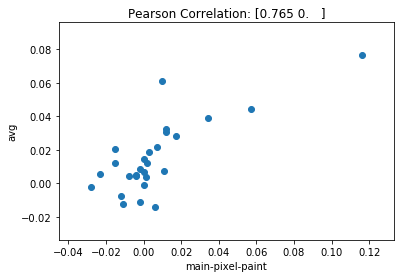

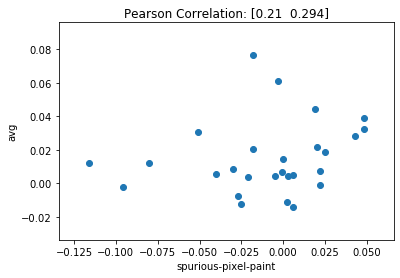

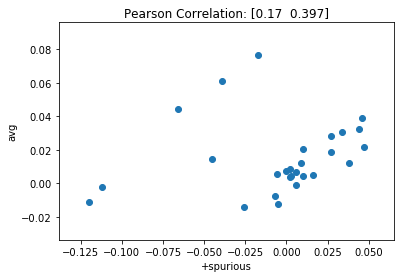

In [5]:

def compare(x, y):
    plt.scatter(diff[x], diff[y])
    plt.xlabel(x)
    plt.ylabel(y)
    c = np.round(pearsonr(diff[x], diff[y]), 3)
    plt.title('Pearson Correlation: {}'.format(c))
    plt.show()
    plt.close()

compare('main-pixel-paint', 'avg')
compare('spurious-pixel-paint', 'avg')
compare('+spurious', 'avg')
